# DESCQA-SRV shear

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook details the DESCQA-SRV shear test. This test covers shear and PSF-related checks, and can be run on the command line for the full dp0.2 catalog using 

```bash
 ./run_master.sh -t srv_shear -c dp02
```

The PSFs in LSST data releases are expected to be computed from the PIFF code. This measures the point spread function from stars in individual visits, and then combines and interpolates them to form a PSF map over the sky. Our SRV-level testing is unlikely to go into more detail than that of the commissioning team, but hopefully it will be useful to help the wider DESC understand the achieved level of data quality and further investigate how any limitations could impact your science. 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import scipy
import scipy.stats
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs
from utils import * 


%matplotlib inline

catalog = GCRCatalogs.load_catalog('lsst_object')

### Star selection for PSFs

Star-galaxy separation and the quality of the psf_candidate sample are addressed in the srv_stars test. Star galaxy separations are typically performed using the extendedness parameter, and then magnitude, color-based or signal to noise cuts can be used to refine stellar samples to reduce galaxy contamination. Stars used for psf determination are labeled by the calib_psf_used flag, those reserved for testing are labeled by the calib_psf_reserved flag, and all candidate stars are labeled by the calib_psf_candidate flag. For more details please see the srv_stars notebook.  


### PSF residuals 

To quantify the accuracy of the PSFs, we look at the measurements of the stars reserved from the PSF sample and compare them to the expected PSF values. These residuals form a good test of the PSF accuracy. 

This is typically done in a few ways 
- look at the size and ellipticity residuals as a function of the focal plane 
- look at the size and ellipticity residuals as a function of their color and magnitude
- look at the rho/Rowe statistics, the correlations of the size and ellipticity residuals expected to contaminate lensing studies

*Note: If anyone can tell me if the true name of these statistics is rho statistics or Rowe statistics I'd be very grateful!

### Rubin testing

The Rubin Observatory LSST project runs a number of tests, here I'm summarising based on [operations rehearsal 3](https://sitcomtn-124.lsst.io/#visit-level-metrics), but you can see what is typically run in the yaml file [here](https://github.com/lsst/analysis_tools/blob/main/pipelines/visitQualityCore.yaml). This overlaps substantially with the list in srv_stars.

#### Calibrated exposures (calexps)
These are typically looking at the differences between the point spread function ellipticity and size with the true point spread function measured at the star position. 
- psfStarDeltaE1/E2 Median and Scatter
- psfStarDeltaSize Median and Scatter
- psfStarScaledDeltaSizeScatter

#### Object Catalog (measured from coadds)
- e1/2Diff: Statistics of residual of e1 ellipticity measurement of sources relative to the PSF (high and low S/N)
- shapeSizeFractionalDiff: Fractional size residuals relative to PSF (high and low S/N) 

There are also tests that are not within the core quality checks but are highly relevant to PSF accuracy, such as the [rho statisics test](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.vector.CalcRhoStatistics.html#lsst.analysis.tools.actions.vector.CalcRhoStatistics). 

## The test

As always, we get started by reading the data! We require the shape measurements to get the size and ellipticities of the stars and PSFs, the reserve star masks to get the points at which to test, and the magnitudes to quantify magnitude-dependent errors. We filter out objects using detect_isPrimary, as well as bad psfFlux values, extendedness values, and shape values. 

In [5]:
# read necessary quantities 
#For stars you typically want to use the PSFflux quantities. 

quantities = ["coord_ra","coord_dec"]
bands = ["r","i","z","g"]
for band in bands:
    quantities.append(band+"_psfFlux")
    quantities.append(band+"_psfFluxErr")
    quantities.append(band+"_calib_psf_candidate")
    quantities.append(band+"_calib_psf_used")
    quantities.append(band+"_calib_psf_reserved")
    quantities.append(band+"_extendedness")
    quantities.append(band+"_ixx")
    quantities.append(band+"_ixy")
    quantities.append(band+"_iyy")
    quantities.append(band+"_ixxPSF")
    quantities.append(band+"_ixyPSF")
    quantities.append(band+"_iyyPSF")
    
filters = ["detect_isPrimary"]
for band in bands:
    filters.append(band+"_psfFlux_flag==False")
    filters.append(band+"_extendedness_flag==False")
    filters.append(band+"_i_flag==False")
    filters.append(band+"_iPSF_flag==False")

data = catalog.get_quantities(quantities, filters=filters)  

ra = data['coord_ra']
dec = data['coord_dec']

# multiple possible definitions of this size, LSST tends to use np.sqrt((data['r_ixx']+data['r_iyy'])/2.)
size={}
size_PSF={}
e_12 = {}
e_12_PSF = {}
mags={}
for band in bands:
    size[band] = data[band+"_ixx"] + data[band+"_iyy"]
    size_PSF[band] = data[band+"_ixxPSF"] + data[band+"_iyyPSF"]
    e_12[band] = e(data[band+"_ixx"],data[band+"_ixy"], data[band+"_iyy"])
    e_12_PSF[band] = e(data[band+"_ixxPSF"],data[band+"_ixyPSF"], data[band+"_iyyPSF"])
    mags[band] = convert_nanoJansky_to_mag(data[band+"_psfFlux"])
    
#we're going to use r,g,i bands to define our samples
mask_stars = (data['i_extendedness']==0)&(data['g_extendedness']==0)&(data['r_extendedness']==0)
mask_candidates = data['g_calib_psf_candidate']&data['i_calib_psf_candidate']&data['r_calib_psf_candidate']
mask_used = data['g_calib_psf_used']&data['i_calib_psf_used']&data['r_calib_psf_used']
mask_reserve = data['g_calib_psf_reserved']&data['i_calib_psf_reserved']&data['r_calib_psf_reserved']

/global/u2/p/plarsen/plarsen_git/srv-dp02/tutorials/test_descriptions/utils.py:10: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


## PSF residuals

We start by plotting the PSF residuals across the sky (remember we're only using a test tract here so it'll look a little funky).

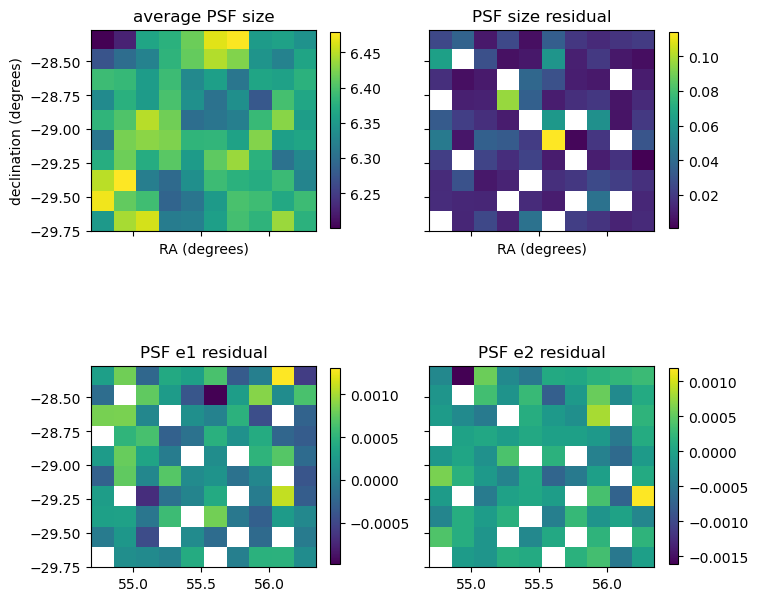

In [7]:
vals, bins1,bins2,counts= scipy.stats.binned_statistic_2d(ra,dec, size_PSF["r"],statistic='mean',bins=10)
vals2, bins1,bins2,counts= scipy.stats.binned_statistic_2d(ra[mask_reserve],dec[mask_reserve], (size['r'][mask_reserve]-size_PSF['r'][mask_reserve])/size_PSF['r'][mask_reserve],statistic='mean',bins=10)
vals3, bins1,bins2,counts= scipy.stats.binned_statistic_2d(ra[mask_reserve],dec[mask_reserve], (e_12['r'][mask_reserve]-e_12_PSF['r'][mask_reserve]).real,statistic='mean',bins=10)
vals4, bins1,bins2,counts= scipy.stats.binned_statistic_2d(ra[mask_reserve],dec[mask_reserve], (e_12['r'][mask_reserve]-e_12_PSF['r'][mask_reserve]).imag,statistic='mean',bins=10)

fig,axs = plt.subplots(2,2, figsize=(8,8), sharey=True, sharex=True)
im1 = axs[0][0].imshow(vals, extent=[bins1[0],bins1[-1],bins2[0],bins2[-1]])
axs[0][0].set_xlabel('RA (degrees)')
axs[0][0].set_ylabel('declination (degrees)')
axs[0][0].set_title('average PSF size')
fig.colorbar(im1, ax=axs[0][0],shrink=0.7)
im2 = axs[0][1].imshow(vals2, extent=[bins1[0],bins1[-1],bins2[0],bins2[-1]])
axs[0][1].set_xlabel('RA (degrees)')
axs[0][1].set_title('PSF size residual')
fig.colorbar(im2, ax=axs[0][1],shrink=0.7)
im3 = axs[1][0].imshow(vals3, extent=[bins1[0],bins1[-1],bins2[0],bins2[-1]])
#axs[2].set_xlabel('RA (degrees)')
axs[1][0].set_title('PSF e1 residual')
fig.colorbar(im3, ax=axs[1][0],shrink=0.7)
im4 = axs[1][1].imshow(vals4, extent=[bins1[0],bins1[-1],bins2[0],bins2[-1]])
#axs[0].set_xlabel('RA (degrees)')
axs[1][1].set_title('PSF e2 residual')
fig.colorbar(im4, ax=axs[1][1],shrink=0.7)
plt.show()



Looking at the above plot of the average PSF size we can see variation over the sky. The size residual will exhibit patterns on the focal plane of the detector, but these are less visible in sky co-ordinates. There will also be atmospheric effects which make visible patterns. It's these residuals though that if correlated will impact measurements. 

Certain effects can be seen in the average residual as a function of magnitude or in color samples. These include brighter-fatter effects or chromatic refraction effects. So let's next plot these as a function of magnitude. We add color bins below for chromatic checks, from Jarvis et. al (add year, DES Y3 PSFs), but with this tract we simply don't have enough stars to do this color cut so we'll hold off on applying that test.  

*Note to self: would be good to expand on this


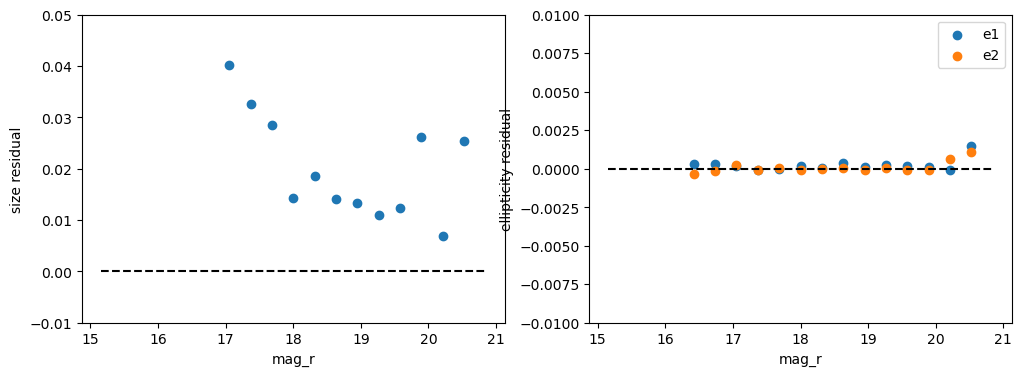

In [9]:
cbin1 = ((mags['r']-mags['z'])<2 )&((mags['r']-mags['z'])>=1.85)
cbin2 = ((mags['r']-mags['z'])<1 )&((mags['r']-mags['z'])>=0.85)
cbin3 = ((mags['r']-mags['z'])<0.05 )&((mags['r']-mags['z'])>=-0.5)

vals, bins, counts = scipy.stats.binned_statistic(mags['r'][mask_reserve],(size['r'][mask_reserve]-size_PSF['r'][mask_reserve])/size_PSF['r'][mask_reserve], bins=np.linspace(15,21,20),statistic='mean')
vals_e1, bins, counts = scipy.stats.binned_statistic(mags['r'][mask_reserve],(e_12['r'][mask_reserve]-e_12_PSF['r'][mask_reserve]).real, bins=np.linspace(15,21,20),statistic='mean')
vals_e2, bins, counts = scipy.stats.binned_statistic(mags['r'][mask_reserve],(e_12['r'][mask_reserve]-e_12_PSF['r'][mask_reserve]).imag, bins=np.linspace(15,21,20),statistic='mean')
m_bin = (bins[1:]+bins[:-1])/2.


fig,axs = plt.subplots(1,2, figsize=(12,4), sharey=False, sharex=True)
axs[0].scatter(m_bin,vals)
axs[0].plot(m_bin,np.zeros_like(m_bin),'k--')
axs[0].set_ylim([-0.01,0.05])
axs[0].set_xlabel('mag_r')
axs[0].set_ylabel('size residual')
axs[1].scatter(m_bin,vals_e1, label='e1')
axs[1].scatter(m_bin,vals_e2, label='e2')
axs[1].plot(m_bin,np.zeros_like(m_bin),'k--')
axs[1].legend()
axs[1].set_ylim([-0.01,0.01])
axs[1].set_xlabel('mag_r')
axs[1].set_ylabel('ellipticity residual')
plt.show()



We're seeing no significant residuals in the ellipticities! There is a pretty clear magnitude dependence in the overall size, which may indicate residual brighter-fatter issues. 

## Rowe statistics

Now we understand a little better what the data actually looks like, let's think about how it'll impact our science. To quantify the actual impact of these PSF residuals on the two-point correlation functions we look at their correlations through the Rowe statistics. The first of these was developed by Rowe 2010, and the remaining 4 were developed in Jarvis et al 2016. 

Non-zero Rowe statistics indicate systematics in the PSF statistics, these have prefactors of order unity so the plots below should show roughly the level of effect on weak lensing autocorrelations.  

*Add equations here



Computing Rowe statistic rho_1 from 196 objects
Computing Rowe statistic rho_2 from 196 objects
Computing Rowe statistic rho_3 from 196 objects
Computing Rowe statistic rho_4 from 196 objects
Computing Rowe statistic rho_5 from 196 objects


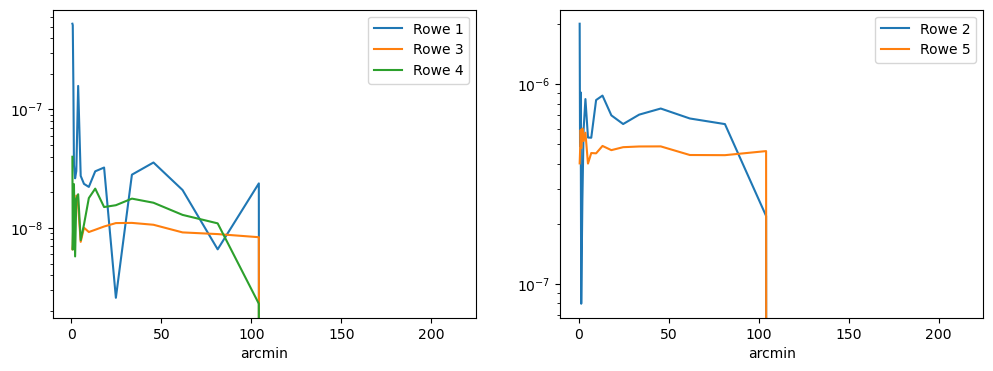

In [11]:
import treecorr
treecorr_config = {
            "min_sep": 0.5,
            "max_sep": 250.0,
            "nbins": 20,
            "bin_slop": 0.01,
            "sep_units": "arcmin",
            "psf_size_units": "sigma",
}

def compute_rowe( i, ra, dec, q1, q2):
    n = len(ra)
    print(f"Computing Rowe statistic rho_{i} from {n} objects")
    corr = treecorr.GGCorrelation(treecorr_config)
    cat1 = treecorr.Catalog(ra=np.array(ra), dec=np.array(dec), g1=np.nan_to_num(q1[0], copy=True, nan=0.0, posinf=None, neginf=None), g2=np.nan_to_num(q1[1], copy=True, nan=0.0, posinf=None, neginf=None), ra_units="deg", dec_units="deg")
    cat2 = treecorr.Catalog(ra=np.array(ra), dec=np.array(dec), g1=np.nan_to_num(q2[0], copy=True, nan=0.0, posinf=None, neginf=None), g2=np.nan_to_num(q2[1], copy=True, nan=0.0, posinf=None, neginf=None), ra_units="deg", dec_units="deg")
    corr.process(cat1, cat2) 
    return corr.meanr, corr.xip, corr.varxip**0.5

de1 = (e_12['r'][mask_reserve]-e_12_PSF['r'][mask_reserve]).real
de2 = (e_12['r'][mask_reserve]-e_12_PSF['r'][mask_reserve]).imag
e1 = e_12['r'][mask_reserve].real
e2 = e_12['r'][mask_reserve].imag
T_f = (size['r'][mask_reserve]-size_PSF['r'][mask_reserve])/size_PSF['r'][mask_reserve]

meanr1, xip1, stdxip1 = compute_rowe(1, ra[mask_reserve], dec[mask_reserve], (de1,de2), (de1,de2))
meanr2, xip2, stdxip2 = compute_rowe(2, ra[mask_reserve], dec[mask_reserve], (e1,e2), (de1,de2))
meanr3, xip3, stdxip3 = compute_rowe(3, ra[mask_reserve], dec[mask_reserve], (e1,e2)*T_f, (e1,e2)*T_f)
meanr4, xip4, stdxip4 = compute_rowe(4, ra[mask_reserve], dec[mask_reserve], (de1,de2), (e1,e2)*T_f)
meanr5, xip5, stdxip5 = compute_rowe(5, ra[mask_reserve], dec[mask_reserve], (e1,e2), (e1,e2)*T_f)


fig,axs = plt.subplots(1,2, figsize=(12,4), sharey=False, sharex=True)
axs[0].plot(meanr1,np.abs(xip1), label = 'Rowe 1')
axs[0].plot(meanr3,np.abs(xip3), label = 'Rowe 3')
axs[0].plot(meanr4,np.abs(xip4), label = 'Rowe 4')
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xlabel('arcmin')
axs[1].plot(meanr2,np.abs(xip2), label = 'Rowe 2')
axs[1].plot(meanr5,np.abs(xip5), label = 'Rowe 5')
axs[1].set_yscale('log')
axs[1].set_xlabel('arcmin')
axs[1].legend()
plt.show()



## How do we improve on this?

As the PSFs are computed ahead of the coadds and is in some way independent of the galaxy sample, it's difficult to create exclusions that would improve these. However, we can look for areas in the map to exclude if they have a strong residual signal, or for issues in specific bands to motivate exclusion from shear studies. In the long term, issues in the results can motivate iterations to the star-galaxy separation, or development of the PIFF code to make improvements. If you'd like to contribute to these studies please get in touch with the pixels-to-objects working group for ways to get involved. 
